# Machine Learning éthique

Ce notebook est inspiré de l'article [FairTest: Discovering Unwarranted Associations in Data-Driven Applications](https://arxiv.org/abs/1510.02377) et propose d'étudier une façon de vérifier qu'un modèle ou une métrique n'est pas biaisé par rapport à certains critères.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Principe

Un problème de machine learning dans sa définition la plus simple consiste à prédire $Y$ en fonction de $I$. On souhaite construire une fonction $f(I)$ qui s'approche le plus possible de $Y$. On appelle $I$ l'ensemble des données utilisateurs ou *user input* et $f(I)$ la sortie du modèle ou *output to users (O)*. On veut découvrir si la sortie du modèle est biaisée d'une façon non-éthique par rapport à des attributs dits protégés ou *protected attributes (S)* tels que l'origine éthnique ou le genre. On tient compte également du contexte, code postal, ...) ou *context attributes (X)* et de variables explicative ou *explanotory attributes (E)*. On a donc :

* **I** : les variables en entrée du modèles,
* **O** : la prédiction du modèle,
* **S** : les attributs protégés, toute corrélation entre la sortie et ces attributs est indésirable,
* **X** : le contexte (principalement le lieu géographique)
* **E** : les variables explicatives (contraintes qualitification), la sortie est a priori corrélée avec ces attributs, de façon quasi prévisible mais cela reste éthique.

Un exemple. Supposons qu'on cherche à recommander un objet à la vente sur un site internet à partir des données de navigation de cette personne (I). Comme cette personne est identifiée, on peut savoir où elle habite (X), son origine éthnique (S) et son niveau d'étude (E). Le site lui recommande un livre de mathématiques (O). Est-ce que cette recommandation dépend principalement de l'origine éthnique (S) ? Et si les deux informations semblent corrélées, ne serait-ce pas plutôt son niveau d'étude (E) qui explique la recommandation ?

Concrètement, la sortie *O* ne dépend que de *I* mais on souhaite savoir si *I* ne serait pas corrélées à certains facteurs qui ne sont pas éthique. C'est une corrélation inattendue mais observable. Le contexte *X* permet de partitionner et de vérifier si le modèle est éthique sur l'ensemble des sous-groupes de population. Le processus de recherche des corrélations indésirées s'effectue en cinq temps.

* On choisit un attribut protégé $S_i$ et on réalise une partition de la population pour cet attribut.
* On vérifie pour chaque sous-population (ou chaque partie) que la sortie *O* et l'attribut $S_i$ ne sont pas corrélés. C'est l'étape de **détection**.
* Pour chaque biais détecté, on vérifie qu'il ne peut être expliqué par une des variables explicatrice auquel ce biais est acceptable. C'est l'étape de **debugging**.

## Installation de FairTest

In [2]:
# !pip install https://github.com/columbia/fairtest/archive/master.zip

## Données

On récupère les données [adult](https://archive.ics.uci.edu/ml/datasets/Adult) pour lequel il faut prédire le fait qu'une personne ait un revenu supérieur à 50.000 dollars par an.

In [3]:
import pyensae.datasource as ds
data = ds.download_data("adult.data", url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/")
names = "age,Workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income".split(",")

In [4]:
import pandas
df = pandas.read_csv(data, names=names)
df.head()

,age,Workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Exemple avec fairtest

Ne fonctionne pas encore. Il faut passer à Python trois.

In [5]:
# from fairtest import DataSource
# data = DataSource(data, budget=1, conf=0.95)

In [6]:
# from fairtest.testing import Testing

SENS = ['sex', 'race']     # Protected features
TARGET = 'income'             # Output
EXPL = ''                     # Explanatory feature

# inv = Testing(data, SENS, TARGET, EXPL)
# print(inv)

## Exercice 1 : Construire un arbre de décision avec son propre critère

On pourra s'inspirer de l'article [Pure Python Decision Trees](http://kldavenport.com/pure-python-decision-trees/),
ou [How To Implement The Decision Tree Algorithm From Scratch In Python](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/). Cet arbre de décision doit produire un résultat similaire à ceci : [Contexte-education-num-in-(9.5, 11.5)-age-in(46.5, inf)](https://github.com/sdpython/fairtest/blob/master/results/report_adult.txt#L35). Il s'agit d'implémenter l'algorithme qui suit avec la métrique [Mutual Information (MI)](https://fr.wikipedia.org/wiki/Information_mutuelle).

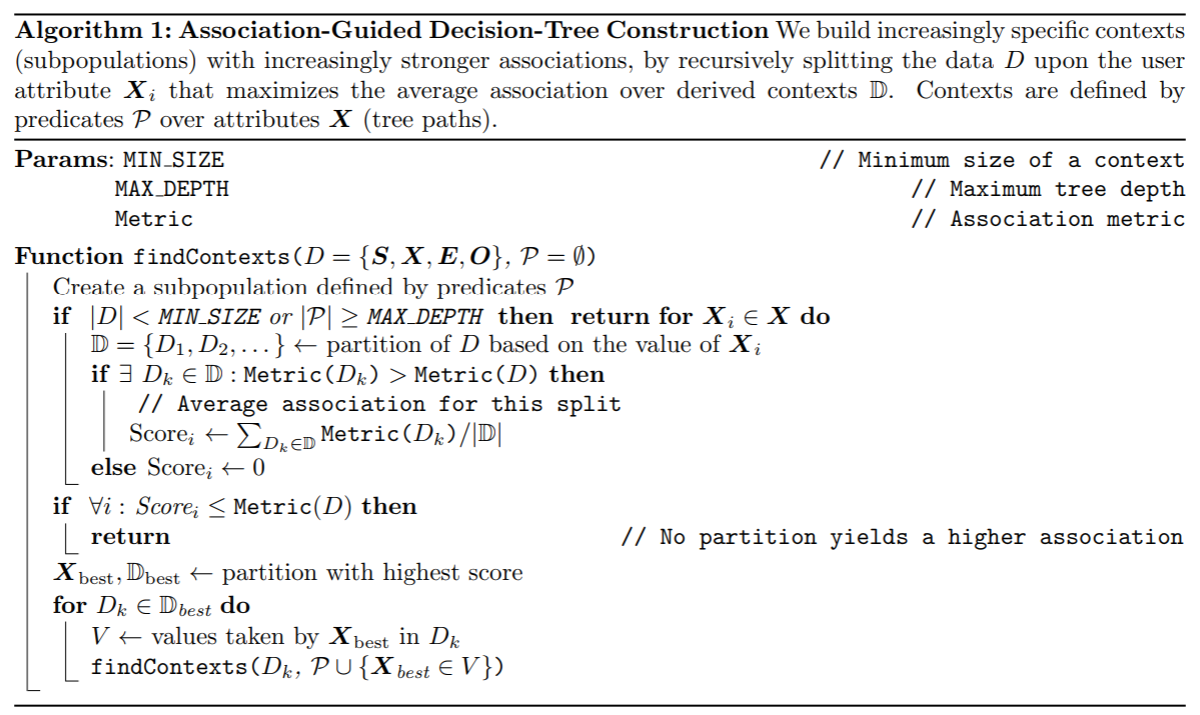

In [7]:
from pyquickhelper.helpgen import NbImage
NbImage("fairtesttree.png")

## Exercice 2 : appliquer l'algorithme sur le jeu de données adulte

## Exercice 3 : apprendre sans interactions

In [10]:
df2 = df.copy()
df2["un"] = 1
df2["age10"] = (df["age"] // 10) * 10
gr = df2[["age10", "sex", "income", "un"]].groupby(["age10", "sex", "income"], as_index=False).sum()
gr.head()

,age10,sex,income,un
0,10,Female,<=50K,809
1,10,Female,>50K,1
2,10,Male,<=50K,846
3,10,Male,>50K,1
4,20,Female,<=50K,3048


In [11]:
g = gr.pivot_table("un", "age10", ["income", "sex"])
g

income   <=50K            >50K        
sex     Female    Male  Female    Male
age10                                 
10       809.0   846.0     1.0     1.0
20      3048.0  4497.0   128.0   381.0
30      2185.0  4119.0   391.0  1918.0
40      1778.0  2735.0   383.0  2279.0
50      1020.0  1691.0   207.0  1500.0
60       554.0   922.0    58.0   481.0
70       162.0   249.0     9.0    88.0
80        24.0    46.0     NaN     8.0
90        12.0    23.0     2.0     6.0

In [12]:
g.columns

MultiIndex(levels=[[' <=50K', ' >50K'], [' Female', ' Male']],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]],
           names=['income', 'sex'])

In [13]:
g["rF"] = g[(" <=50K", " Female")] / g[(" >50K", " Female")]
g["rM"] = g[(" <=50K", " Male")] / g[(" >50K", " Male")]
g

income   <=50K            >50K                  r1          r2          rF  \
sex     Female    Male  Female    Male                                       
age10                                                                        
10       809.0   846.0     1.0     1.0  809.000000  846.000000  809.000000   
20      3048.0  4497.0   128.0   381.0   23.812500   11.803150   23.812500   
30      2185.0  4119.0   391.0  1918.0    5.588235    2.147550    5.588235   
40      1778.0  2735.0   383.0  2279.0    4.642298    1.200088    4.642298   
50      1020.0  1691.0   207.0  1500.0    4.927536    1.127333    4.927536   
60       554.0   922.0    58.0   481.0    9.551724    1.916840    9.551724   
70       162.0   249.0     9.0    88.0   18.000000    2.829545   18.000000   
80        24.0    46.0     NaN     8.0         NaN    5.750000         NaN   
90        12.0    23.0     2.0     6.0    6.000000    3.833333    6.000000   

income          rM  
sex                 
age10               
10      846.000000  
20       11.803150  
30        2.147550  
40        1.200088  
50        1.127333  
60        1.916840  
70        2.829545  
80        5.750000  
90        3.833333

Les deux variables paraissent corrélées.

On apprend trois modèles :
    
* On prédit 'income' avec l'âge et le genre, modèle M0
* On prédit 'income' avec l'âge uniquement, modèle M1
* On prédit 'income' avec le genre uniquement, modèle M2
* On prédit 'income' avec les modèles M1 et M2.

Le modèle prédit-il aussi bien, moins bien ? Qu'en déduisez-vous ?